In [2]:
import vcfpy
import multiprocessing
import functools
import matplotlib.pyplot as plt
# By biomedical_informatics Edris Sharif Rahmani Jun 12, 2023
def process_record(record, 
                   lock, 
                   total_variants, 
                   snps, 
                   indels, 
                   purine_substitutions, 
                   pyrimidine_substitutions):
    with lock:
        total_variants.value += 1
    if record.is_snv():
        with lock:
            snps.value += 1
        ref_base = record.REF
        alt_bases = [alt.value for alt in record.ALT]
        for alt_base in alt_bases:
            if is_purine(ref_base) and is_purine(alt_base):
                with lock:
                    purine_substitutions.value += 1
            elif is_pyrimidine(ref_base) and is_pyrimidine(alt_base):
                with lock:
                    pyrimidine_substitutions.value += 1
    else:
        with lock:
            indels.value += 1

def calculate_statistics(input_vcf_file):
    vcf_reader = vcfpy.Reader.from_path(input_vcf_file)

    manager = multiprocessing.Manager()
    lock = manager.RLock()
    total_variants = manager.Value('i', 0)
    snps = manager.Value('i', 0)
    indels = manager.Value('i', 0)
    purine_substitutions = manager.Value('i', 0)
    pyrimidine_substitutions = manager.Value('i', 0)

    pool = multiprocessing.Pool()

    partial_process_record = functools.partial(
        process_record,
        lock=lock,
        total_variants=total_variants,
        snps=snps,
        indels=indels,
        purine_substitutions=purine_substitutions,
        pyrimidine_substitutions=pyrimidine_substitutions
    )
    pool.map(partial_process_record, vcf_reader)

    pool.close()
    pool.join()

    total_variants_value = total_variants.value
    snps_value = snps.value
    indels_value = indels.value
    purine_substitutions_value = purine_substitutions.value
    pyrimidine_substitutions_value = pyrimidine_substitutions.value

    # Pie chart for SNP vs Indels
    labels = ['SNPs', 'Indels']
    sizes = [snps_value, indels_value]
    colors = ['#B7950B', '#1E8449']
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('SNPs vs Indels')
    plt.show()
    if purine_substitutions_value > 0 or pyrimidine_substitutions_value > 0:
        labels = ['Purine Substitutions', 'Pyrimidine Substitutions']
        sizes = [purine_substitutions_value, pyrimidine_substitutions_value]
        colors = ['#B7950B', '#1E8449']
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
        plt.axis('equal')
        plt.title('Purine Substitutions vs Pyrimidine Substitutions')
        plt.show()
    else:
        print('No purine or pyrimidine substitutions found.')

def is_purine(base):
    return base in ['A', 'G']

def is_pyrimidine(base):
    return base in ['C', 'T']

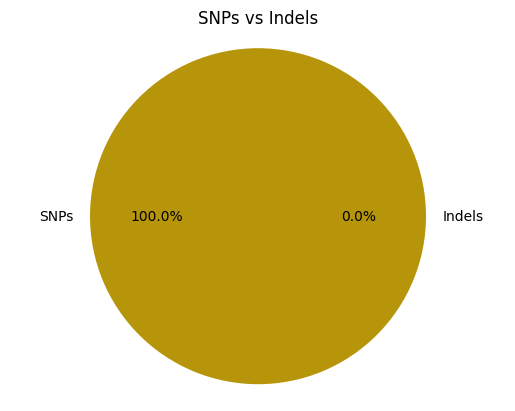

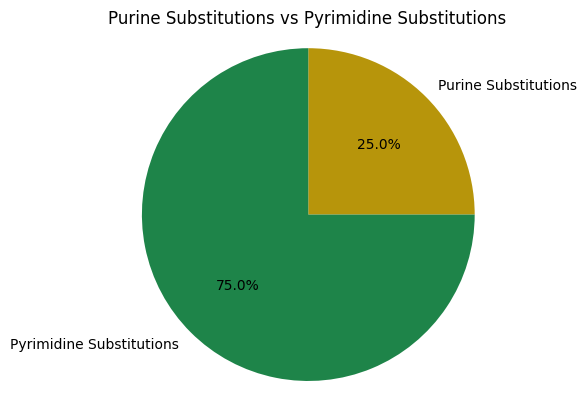

In [3]:
calculate_statistics('input.vcf')